# Clustering Headlines Based on Location

## Applying Clustering Algorithms to Find Geographically Similar Headlines

__Objective__: Cluster (find groups of) headlines based on the geographic coordinates using both KMeans clustering and DBSCAN. Visualize the clusters on a world map to check the results. Try different parameters and distance measures in the algorithms to produce better clusters. The clusters will be used to find disease outbreaks in the next part.

__Workflow__:
1.	Apply KMeans clustering and the DBSCAN algorithm to the latitude and longitude of each headline. 
    -	Use the default initial parameters for the algorithm or, if you have prior experience, choose parameters you think will work well.
    -	Assign the cluster labels as another column on the DataFrame.
2.	Visualize the clusters on a world map using the Basemap library. Color the headlines by the cluster assignment.
    -	Determine if the clusters are reasonable: are headlines geographically close to one another in the same cluster?
    -	Write a visualization function to quickly check clustering results.
3.	In the likely case that the first clustering is not ideal, adjust the parameters of the algorithm you choose or use a different algorithm.
    -	You can use an elbow plot to select the number of clusters in KMeans.
    -	The two most important parameters for DBSCAN are `eps` and `min_samples`
4.	Try using DBSCAN with the great circle distance, which finds the distance between two geographic points on a spherical globe.
    -	Write a function to return the Great Circle distance between two coordinate points.
    -	Use this function as the `metric` for DBSCAN
5.	Repeat the above steps—cluster, visualize, analyze, tune—as many times as is required until the algorithm correctly assigns close points to the same cluster without too many outliers.

__Deliverable__:

The deliverable from this section is another Jupyter Notebook documenting your work as you cluster the headlines with the coordinates and produce a world map with clustered headlines. The map should show the locations of headlines colored by the cluster assignment. We will use this DataFrame and map to find disease outbreaks in the next section.

### Read in and Examine Data

First, let's read in our data and make sure it looks right. We want to check there are no missing values and the data types are floats for latitude and longitude.

In [2]:
import pandas as pd

data = pd.read_csv('processed_headlines_locations.csv', index_col=0)
data[['headline', 'city', 'latitude', 'longitude', 'countrycode']].head()

headline           city  latitude  \
0                 Zika Outbreak Hits Miami          Miami  25.77427   
1          Could Zika Reach New York City?  New York City  40.71427   
2        First Case of Zika in Miami Beach    Miami Beach  25.79065   
3  Mystery Virus Spreads in Recife, Brazil         Recife  -8.05389   
4  Dallas man comes down with case of Zika         Dallas  32.78306   

   longitude countrycode  
0  -80.19366          US  
1  -74.00597          US  
2  -80.13005          US  
3  -34.88111          BR  
4  -96.80667          US

In [3]:
print('Missing Values:')
data.isna().sum()

Missing Values:


headline         0
city             0
accented_city    0
latitude         0
longitude        0
countrycode      0
pop              0
dtype: int64

There are no missing values since we handled those in the previous section.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605 entries, 0 to 646
Data columns (total 7 columns):
headline         605 non-null object
city             605 non-null object
accented_city    605 non-null object
latitude         605 non-null float64
longitude        605 non-null float64
countrycode      605 non-null object
pop              605 non-null float64
dtypes: float64(3), object(4)
memory usage: 37.8+ KB


The data types look correct for `latitude` and `longitude`. 

# Clustering using DBSCAN

For our first clustering method, we'll use the the [DBSCAN algorithm](https://en.wikipedia.org/wiki/DBSCAN), specifically the implementation in the [`DBSCAN` module from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). DBSCAN: Density-Based Spatial Clustering of Applications with Noise, is a density-based algorithm for clustering a set of points that works by grouping together (clusters) points with many close neighbors. Close is defined using a distance measure such as "euclidean" and points with no neighbors are marked as outliers. (Another clustering method we can try later is K-Means clustering.)

There are many parameters in DBSCAN, but we'll initally use the default values, hoping [they are reasonable](https://arxiv.org/abs/1309.0238)!

In [5]:
from sklearn.cluster import DBSCAN

# Default sklearn parameters
clusterer = DBSCAN()
clusterer

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

### Distance Metric: Euclidean

We are using the ["euclidean" distance metric](https://en.wikipedia.org/wiki/Euclidean_distance) which is the straight line distance between two points. Since we are dealing with latitude and longitude on a spherical Earth, the euclidean distance is not the true distance between points but we can try it nonetheless.

We can directly fit the `clusterer` object on the `latitude` and `longitude` columns. We'll make a quick function to cluster a given data set with a model.

In [6]:
def cluster_location(clusterer, data, lat_string="latitude", lon_string="longitude"):
    """
    Fit a clustering algorithm on location data.
    """
    features = data[[lat_string, lon_string]].copy()
    clusterer.fit(features)
    # Assign the cluster labels
    data["cluster"] = clusterer.labels_
    return data

To get a rough idea of the cluster distribution, we'll look at the number of headlines in each cluster.

In [7]:
data = cluster_location(clusterer, data)
data['cluster'].value_counts()

-1    476
 4     26
 1     21
 0     19
 6     14
 7     12
 3     12
 5      8
 9      6
 2      6
 8      5
Name: cluster, dtype: int64

__-1 in this library indicates the point is _an outlier (noise)_ and has not been assigned to any cluster.__ The [documentation says](https://scikit-learn.org/stable/modules/clustering.html#dbscan) we can try adjusting the parameters to reduce the number of unassigned points, or it may be we have noisy data and many of the headlines do not belong to a cluster. 

## Adjusting Parameters

It's time to dig into the DBSCAN algorithm parameters. We can learn what these do from the [parameter documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). (For now, we won't adjust the metric used which by default is the `euclidean` distance between points.) We can also refer to the [Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/clustering.html#dbscan) on DBSCAN to determine which parameters to adjust. 

Based on the documentation, the most important parameters are:

1. `eps`: "The maximum distance between two samples for one to be considered as in the neighborhood of the other."
2. `min_samples`: "The number of samples (or total weight) in a neighborhood for a point to be considered as a core point."

Let's start with the most important parameter, `eps`, or the distance between points.

### eps

The `eps` parameter is the "maximum distance between two samples for one to be considered in the neighborhood of the other." According to the documentation, this is the most important parameter. To try and put more headlines in each cluster, we can increase eps. 

Since we are using euclidean distance with latitude and longitude, we can't interpret `eps` as representing miles or another distance unit. This will be addressed when we try a different distance metric.

In [8]:
clusterer.eps = 9
data = cluster_location(clusterer, data)
data['cluster'].value_counts()

 0     371
 2      59
 3      57
-1      32
 1      21
 5      16
 8       9
 4       9
 6       8
 11      7
 9       6
 7       6
 10      4
Name: cluster, dtype: int64

Increasing `eps` significantly decreased the number of points not in a cluster and resulted in several prominent clusters of headlines. This is as expected, because we allow points to be farther away from each other but still in the same cluster.

### Minimum Number of Samples

The `min_sample_size` controls the minimum number of samples in a neighborhood for a point to be "considered a core point". We can think of this as the minimum number of cities that must be in a cluster. We'll reduce the value from the default 5 to 3 which hopefully should put more headlines in clusters. 

This may also increase the number of clusters since we allow smaller clusters.

In [9]:
clusterer.min_samples = 3
data = cluster_location(clusterer, data)
data['cluster'].value_counts()

 0     373
 4      62
 2      59
 1      21
-1      16
 8      16
 11      9
 10      9
 5       9
 9       8
 12      6
 7       6
 3       5
 13      3
 6       3
Name: cluster, dtype: int64

We have reduced the number of headlines not in a cluster, but created several more clusters. Let's use these parameters as the "best" for now and visualize the results on a map.

In [10]:
best_euclidean_clusterer = DBSCAN(
    eps=9, min_samples=3, metric="euclidean",
)
data = cluster_location(best_euclidean_clusterer, data)

# Visualizing Clusters

Even without a perfect clustering (yet), we can try to visualize these clusters. We'll use the Python library `basemap` which works with matplotlib.

To install basemap, follow the directions on the [GitHub repository](https://github.com/matplotlib/basemap) or use the `environment.yml` file in the base GitHub repository and install with conda. (It should be noted that Basemap is transitioning over to Cartopy, and should not be used for new projects.

The [Basemap documentation](https://basemaptutorial.readthedocs.io/en/latest/index.html#basemap-tutorial) gives us all the help we need for creating a map of the world. We'll color the headlines by the cluster assignment to evaluate the results.

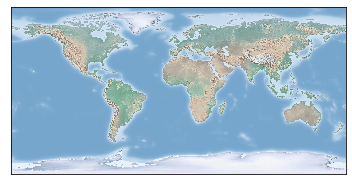

In [11]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18

%matplotlib inline

# Simple world map
m = Basemap()
_ = m.shadedrelief()

Drawing a simple map with `basemap` is very easy. Now, we have to map the latitude and longitude onto the map. This requires converting the latitude and longitude coordinates to the map coordinates.

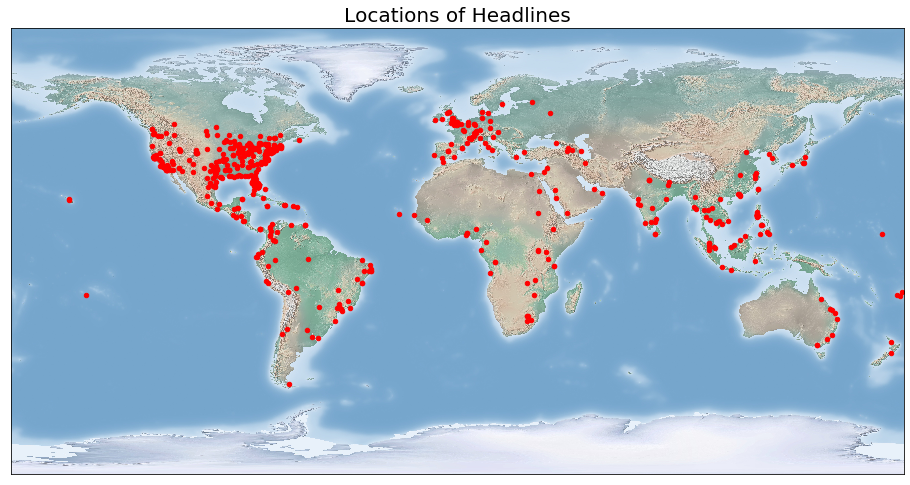

In [12]:
import matplotlib.pyplot as plt

# Make an empty figure
plt.figure(figsize=(16, 10))

# Convert the longitude, latitude to map projection coordinates
x, y = m(x=data["longitude"], y=data["latitude"])

m.shadedrelief()

# Plot the headline locations
plt.scatter(x, y, 20, marker="o", color="red")

# Grab the current axis to set the title (gca)
ax = plt.gca()
_ = ax.set_title("Locations of Headlines", size=20)

Fortunately our coordinates look to be correct! Geographic plotting can be tricking, notably getting the coordinate system and transformations correct.

## Plotting Clusters

Now, we need to associate colors with each cluster. The easiest way to do this is to iterate through each cluster and plot one cluster at a time with a different color. We'll add a legend for interpretation.

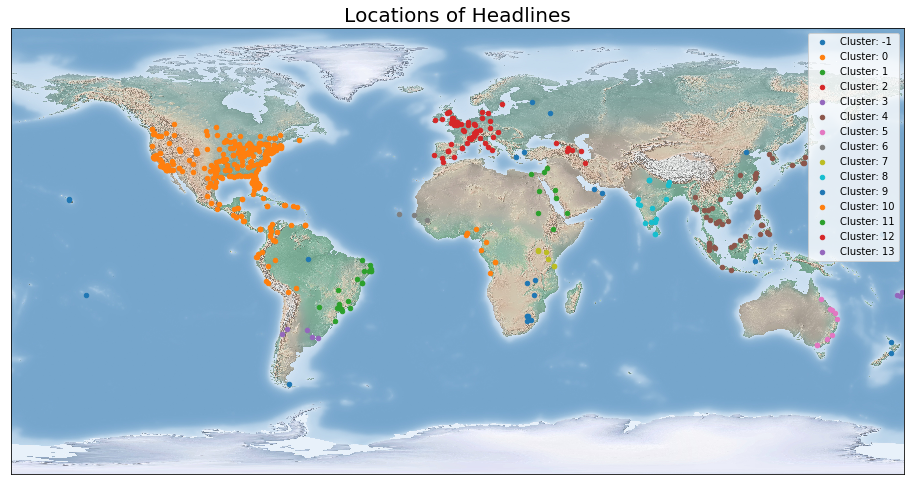

In [13]:
plt.figure(figsize=(16, 10))

m.shadedrelief()
data["x"], data["y"] = x, y

# Iterate through each cluster and plot
for cluster, grouped in data.groupby("cluster"):
    plt.scatter(grouped["x"], grouped["y"], 20, marker="o", label=f"Cluster: {cluster}")

# Grab the figure to set the title and make a legend
ax = plt.gca()
ax.legend()
_ = ax.set_title("Locations of Headlines", size=20)

Now we have a map with each point colored by cluster membership. We can put our plotting code into a function to make our plots repeatedly. We'll color points not in any cluster black and let matplotlib choose colors for other clusters.

In [14]:
def plot_clusters(data):
    """
    Plot clustered data on a basemap.
    """
    plt.figure(figsize=(16, 10))
    m.shadedrelief()

    # Iterate through each cluster and plot
    for cluster, grouped in data.groupby("cluster"):
        if cluster == -1:
            # Handle the unassigned headlines
            plt.scatter(
                grouped["x"],
                grouped["y"],
                s=60,
                alpha=0.8,
                marker="o",
                label=f"Cluster: None",
                c="k",
            )
        else:
            plt.scatter(
                grouped["x"],
                grouped["y"],
                s=60,
                alpha=0.8,
                marker="o",
                label=f"Cluster: {cluster}",
            )

    # Add a legend and title (put legend to right of plot)
    ax = plt.gca()
    ax.legend(loc=(1, 0))
    _ = ax.set_title("Locations of Headlines", size=20)

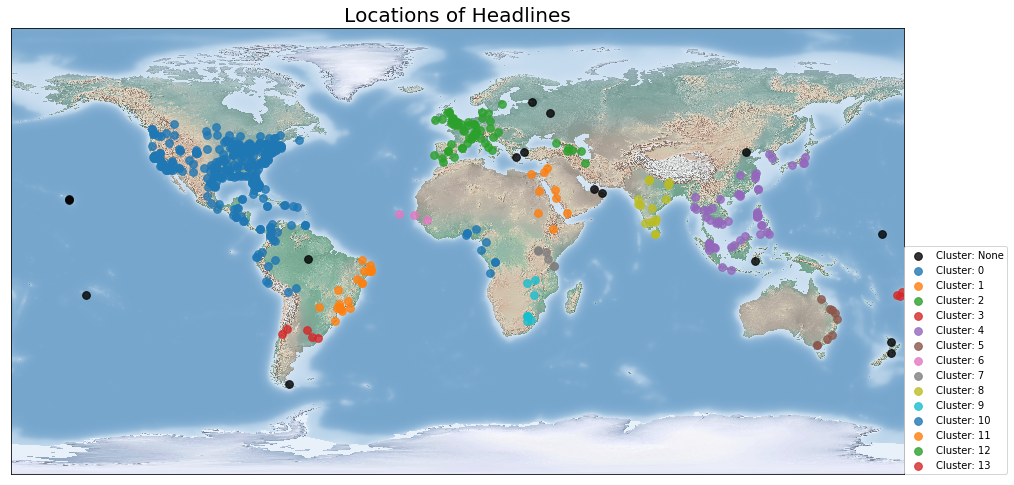

In [16]:
plot_clusters(data)
plt.savefig('euclidean_clustering_map.png')

## Results Interpretation: Are Clusters Reasonable?

From the clusters, it appears the algorithm is not doing an awful job of grouping headlines that are close to one another together, but it also makes some mistakes. There are a number of points not assigned to any cluster that should be in a cluster, and there are some clusters spread across vast distances that do not make sense. 

Overall, the clusters are reasonable and appear accurate enough for the needs of WHO. Hopefully, we can do even better by using a different distance measure, one that more accurately accounts for the curvature of the Earth. In the next section,  we will try the same clustering algorithm but using the [Great Circle distance](https://en.wikipedia.org/wiki/Great-circle_distance) to accurately measure the distance between geographic coordinates.

# Great Circle Distance and the Haversine Formula

The Great Circle Distance is the shortest distance between two points on a sphere when following the outline of the sphere. (The Euclidean distance would give us the straight line distance between two points but passes through the sphere). To improve the clustering, we'll use the Great Circle Distance as the metric in DBSCAN.

The [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) is one method for computing the Great Circle distance between two points on a sphere. It is different from the Euclidean metric because it takes into account the curvature of the Earth. 

## Implementation

To use the Haversine formula, we have to write a function which returns the Great Circle distance between two latitude and longitude `numpy` arrays. The Haversine Formula is implemented in Python in [this Stack Overflow answer](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points) and we'll change the implementation to work on arrays instead of two points.

In [17]:
import numpy as np

def great_circle_distance(coord1, coord2, radius=3956):
    """
    Calculates the great circle distance between two coordinates or arrays of coordinates.
    """
    if np.array_equal(coord1, coord2):
        return 0.0

    # Convert lat/lon to radians
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    # Find the difference between the coordinates
    delta_x, delta_y = coord2 - coord1
    
    # Apply Haversin formula
    haversin = np.sin(delta_x / 2) ** 2 + np.product(
        [np.cos(coord1[0]), np.cos(coord2[0]), np.sin(delta_y / 2) ** 2]
    )

    # Convert to distance in miles
    return 2 * radius * np.arcsin(haversin ** 0.5)

When we pass in coordinates, each column of the array should be a point. The first row contains the latitude and the second the longitude.

Let's test this on our first three headlines.

In [18]:
data.head()

headline           city  accented_city  \
0                 Zika Outbreak Hits Miami          Miami          Miami   
1          Could Zika Reach New York City?  New York City  New York City   
2        First Case of Zika in Miami Beach    Miami Beach    Miami Beach   
3  Mystery Virus Spreads in Recife, Brazil         Recife         Recife   
4  Dallas man comes down with case of Zika         Dallas         Dallas   

   latitude  longitude countrycode        pop  cluster         x         y  
0  25.77427  -80.19366          US   441003.0        0 -80.19366  25.77427  
1  40.71427  -74.00597          US  8175133.0        0 -74.00597  40.71427  
2  25.79065  -80.13005          US    92312.0        0 -80.13005  25.79065  
3  -8.05389  -34.88111          BR  1478098.0        1 -34.88111  -8.05389  
4  32.78306  -96.80667          US  1300092.0        0 -96.80667  32.78306

In [19]:
coord1 = np.array(
    [
        [data["latitude"].iloc[0], data["latitude"].iloc[1]],
        [data["longitude"].iloc[0], data["longitude"].iloc[1]],
    ]
)

coord2 = np.array(
    [
        [data["latitude"].iloc[2], data["latitude"].iloc[0]],
        [data["longitude"].iloc[2], data["longitude"].iloc[0]],
    ]
)

# Calculate distance between points
great_circle_distance(coord1, coord2)

array([   1.14462609, 1031.53567987])

We get 1.14 miles between Miami and Miami Beach, and 1031.5 miles between New York City and Miami. If we check this against an [online calculator](http://movable-type.co.uk/scripts/latlong.html) we see our answer is in agreement (1757 km = 1091 miles).

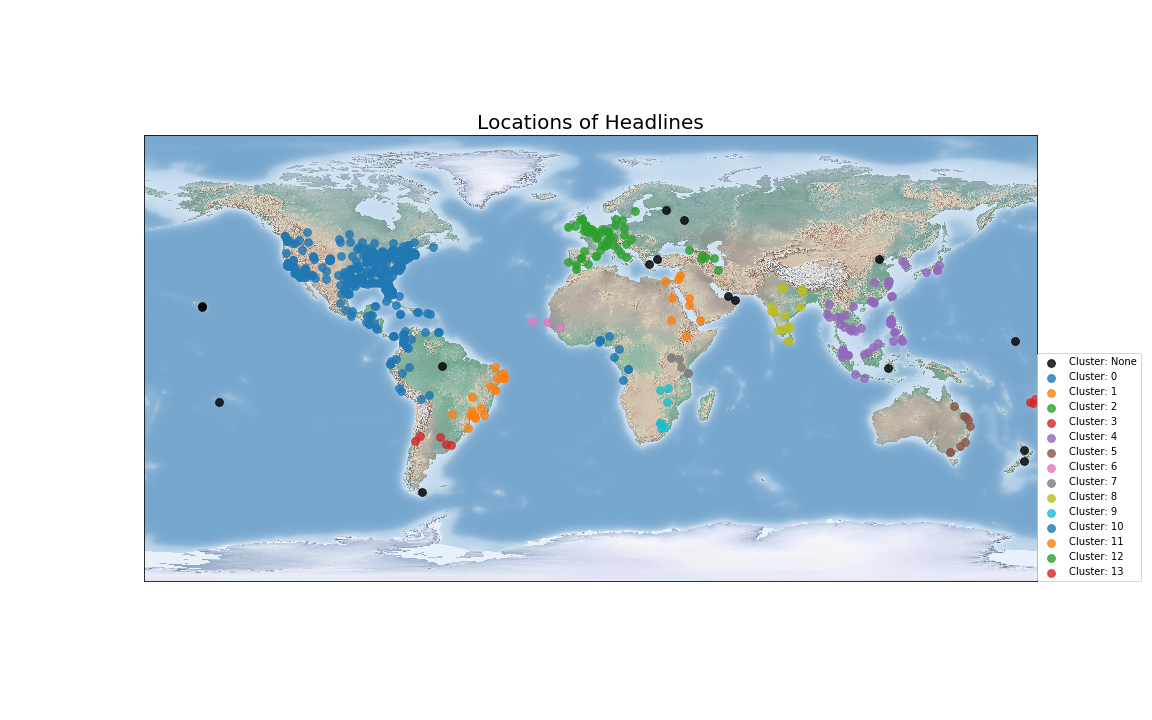

In [23]:
from IPython.display import Image
Image('euclidean_clustering_map.png')

### Using Great Circle Distance

To use the Great Circle Distance, we pass in the metric function (a callable) to the `metric` keyword parameter. We'll use a slightly different value - 250 miles - for `eps` now that we are using distance in miles between points. The `min_samples` will increase to 4 cities.

In [24]:
great_circle_clusterer = DBSCAN(
    eps=250, min_samples=4, metric=great_circle_distance,
)

# Cluster using great circle distance
data = cluster_location(
     great_circle_clusterer, data, lon_string="longitude", lat_string="latitude"
)

data["cluster"].value_counts()

 0     237
-1     133
 5      59
 2      49
 4      16
 10     11
 6      11
 8      10
 9       9
 11      8
 16      8
 3       8
 7       7
 1       6
 14      5
 12      4
 20      4
 18      4
 13      4
 15      4
 17      4
 19      4
Name: cluster, dtype: int64

The clustering distribution has changed significantly. Let's check these clusters on a map.

### Great Circle Clustering Map

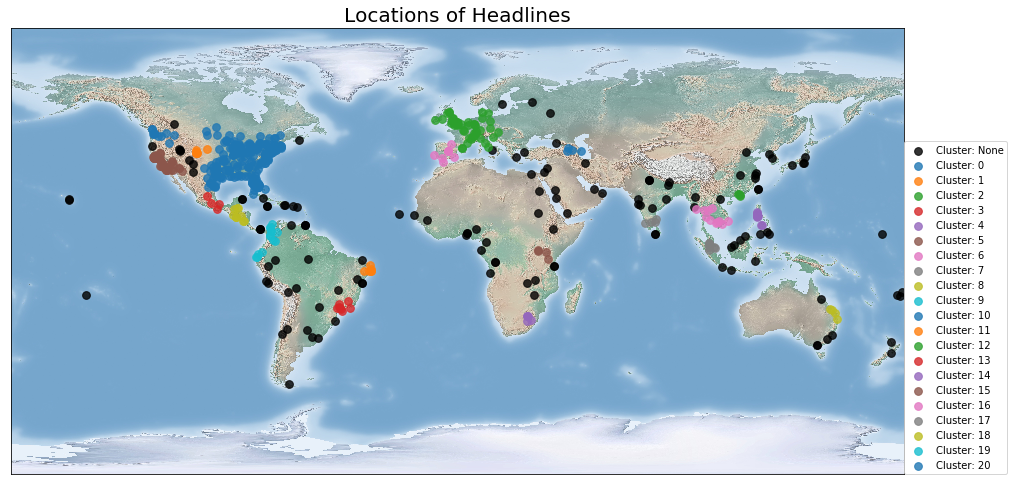

In [25]:
_ = plot_clusters(data)

For comparison, we should visualize the clusters from using the Euclidean distance.

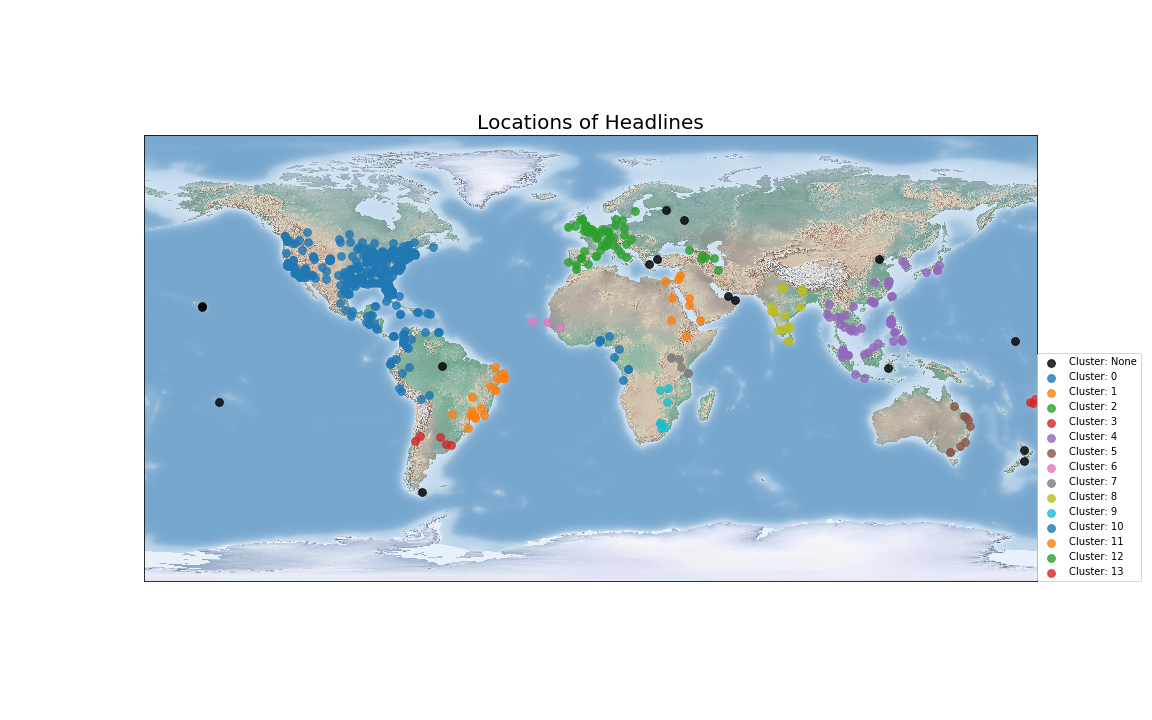

In [27]:
from IPython.display import Image
Image('euclidean_clustering_map.png')

Each clustering has mistakes, but overall, the Euclidean clustering appears better. 

As one more experiment, let's trying using the Manhattan Distance between points for the metric. This simply adds together the x and y differences to get a total distance between points.

In [28]:
manhattan_clusterer = DBSCAN(
    eps=9, min_samples=3, metric="manhattan",
)
data = cluster_location(manhattan_clusterer, data)

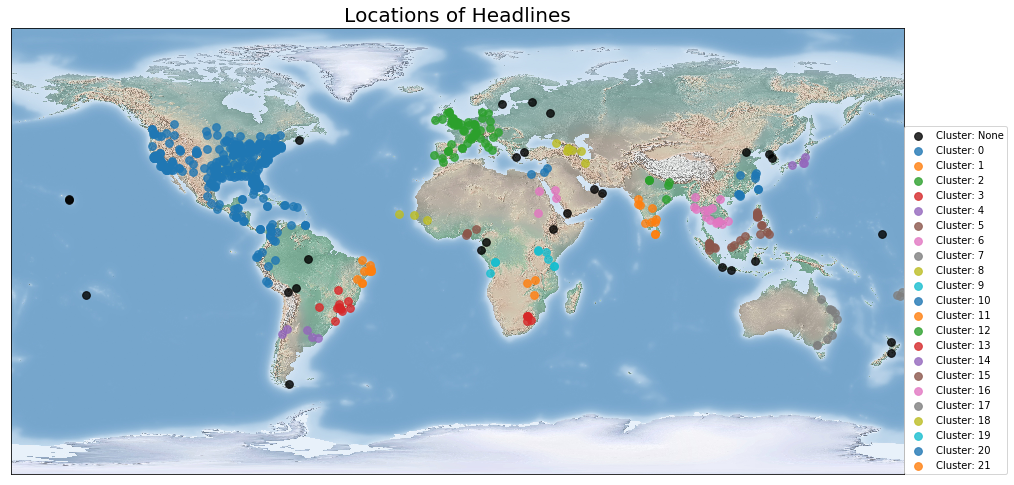

In [29]:
_ = plot_clusters(data)

These clusters also look reasonable, but the `euclidean` metric appears to produce the best clusters. We'll switch back to that.

# KMeans

The second method to try for clustering is the [KMeans algorithm](https://en.wikipedia.org/wiki/K-means_clustering). KMeans places data points into k clusters - chosen ahead of time by the programmer - where each data point belongs to the cluster with the nearest mean. We'll use Scikit-Learn ([sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) for the implementation.  

In [30]:
from sklearn.cluster import KMeans

kmeans_clusterer = KMeans()
kmeans_clusterer

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

We'll try a range of values for the number of clusters, `n_clusters`. For each value, we'll record the `inertia`, the within-cluster sum-of-squares criterion. This is the loss KMeans attempts to minimize. 

In [31]:
inertia_values = []

for k in range(1, 11):
    inertia_values.append(KMeans(n_clusters=k).fit(data[['latitude', 'longitude']]).inertia_)

We can now make an elbow plot of the inertia values to find the ideal number of clusters.

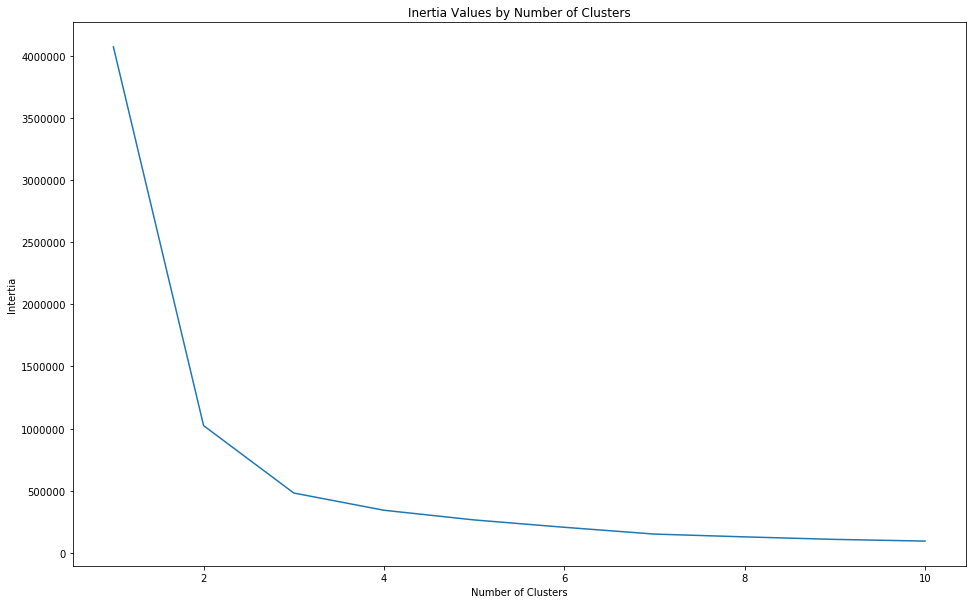

In [32]:
plt.figure(figsize=(16, 10))
plt.plot(range(1, 11), inertia_values);
plt.title('Inertia Values by Number of Clusters');
plt.xlabel('Number of Clusters');
plt.ylabel('Intertia');

The elbow of the plot is at 3 clusters. At this value, we get a low inertia without a large number of clusters.

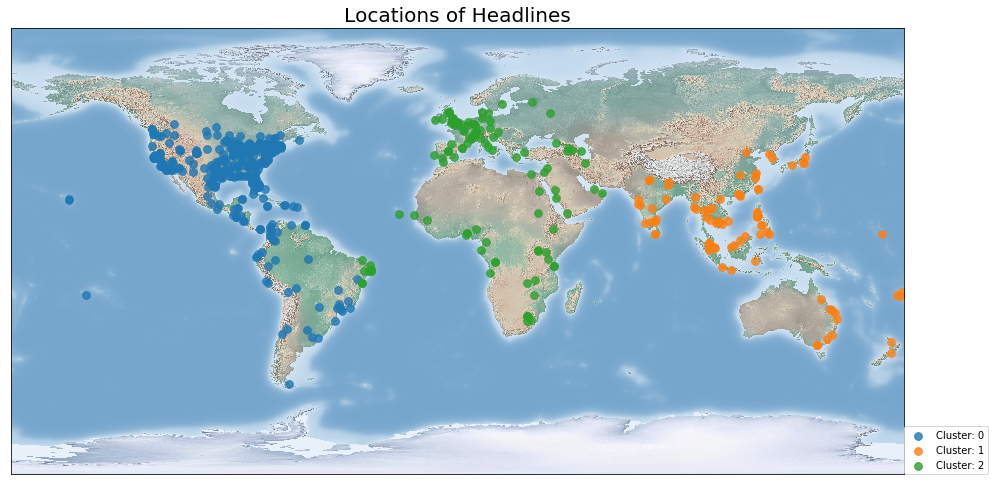

In [33]:
kmeans_clusterer = KMeans(n_clusters=3)
data = cluster_location(kmeans_clusterer, data)
plot_clusters(data)

Three clusters appears to be too few. Let's increase it to 8. 

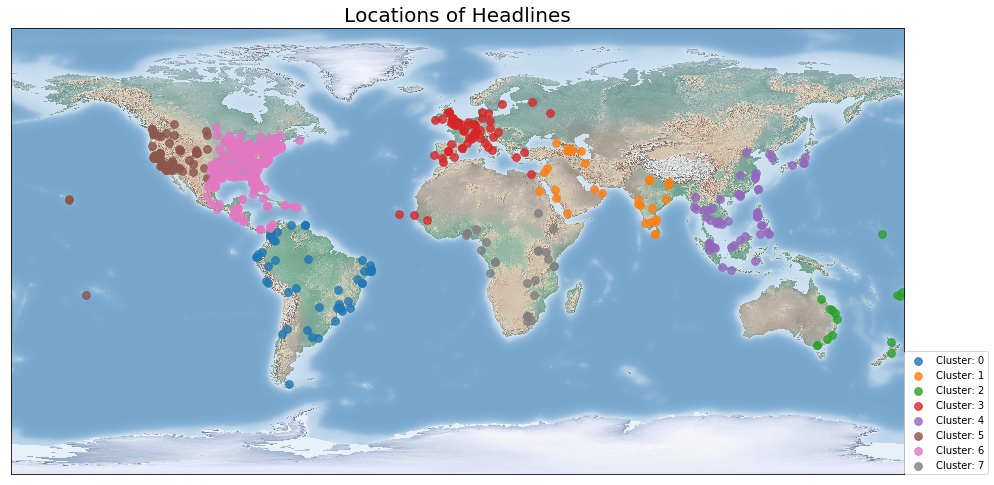

In [34]:
kmeans_clusterer = KMeans(n_clusters=8)
data = cluster_location(kmeans_clusterer, data)
plot_clusters(data)

## Limitations of KMeans

Using 8 clusters produces reasonable groups of headlines. However, KMeans is limited because it must assign every point to a cluster when clearly there are outlying headlines that should not belong to any group. We don't want to end up with false negatives because these outliers are assigned to a cluster. For this reason, we will use the DBSCAN algorithm with our selected parameters and the "euclidean" metric for the remainer of the project.

# World Plot

For the final output of this section, we'll create a plot using the best-identified clusterer without the outliers.

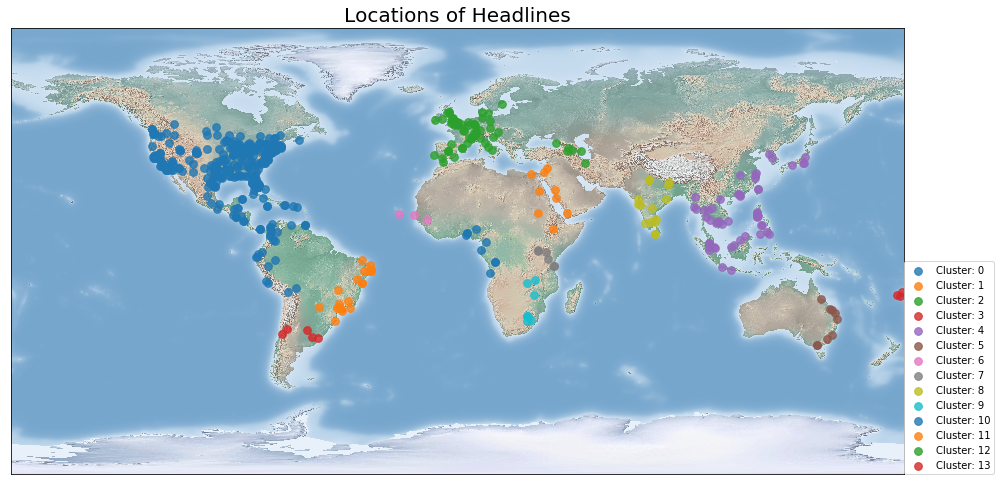

In [36]:
best_clusterer = DBSCAN(eps=9, metric="euclidean", min_samples=3)
data = cluster_location(best_clusterer, data)
plot_clusters(data[data['cluster'] != -1])
plt.savefig('entire_world_clustering.png')

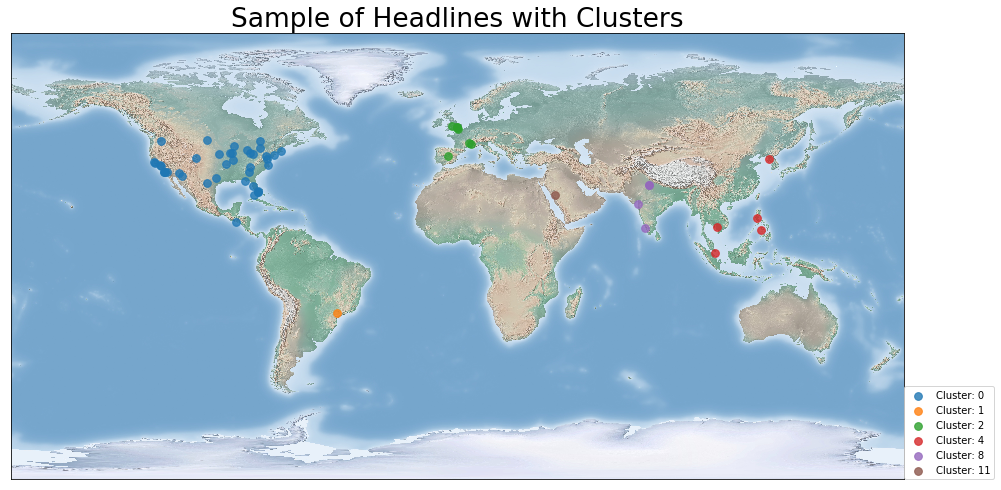

In [37]:
plot_clusters(data[data['cluster'] != -1].sample(frac=0.10))
ax = plt.gca()
plt.rcParams['font.size'] = 22
ax.set_title('Sample of Headlines with Clusters');

## Cluster Distribution

The clusters are not great - noticeably the entire United States is in one cluster. The distributions of points in clusters is also skewed, with one massive cluster and several smaller ones with only a few headlines.

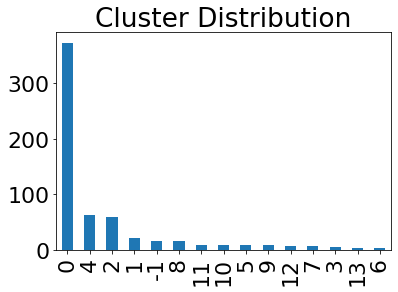

In [38]:
_ = data['cluster'].value_counts().plot.bar(title='Cluster Distribution')

Nearly half of the headlines are from the United States, so we might have to cluster the data separately.

In [39]:
data.groupby('countrycode')['cluster'].value_counts()['US']

cluster
 0    302
-1      2
Name: cluster, dtype: int64

Given the skewed distribution from the United States, it will make sense to cluster the US and the world separately. We'll do this in the next notebook. For now, we know how to use the algorithms and can see there are definitely groups of headlines which may indicate disease outbreaks. 

In [41]:
data.to_csv('processed_headlines_clustered.csv')

# Output

The output from this section is:

1. The dataframe with the cluster assignments.
2. The world map with the headlines plotted and colored by cluster assignment.

In [42]:
data[['headline', 'city', 'latitude', 'longitude', 'countrycode', 'cluster']].head(10)

headline           city  latitude  \
0                 Zika Outbreak Hits Miami          Miami  25.77427   
1          Could Zika Reach New York City?  New York City  40.71427   
2        First Case of Zika in Miami Beach    Miami Beach  25.79065   
3  Mystery Virus Spreads in Recife, Brazil         Recife  -8.05389   
4  Dallas man comes down with case of Zika         Dallas  32.78306   
5        Trinidad confirms first Zika case       Trinidad -14.83333   
6   Zika Concerns are Spreading in Houston        Houston  29.76328   
7    Geneve Scientists Battle to Find Cure         Geneve  46.20222   
8    The CDC in Atlanta is Growing Worried        Atlanta  33.74900   
9       Zika Infested Monkeys in Sao Paulo      Sao Paulo -23.54750   

   longitude countrycode  cluster  
0  -80.19366          US        0  
1  -74.00597          US        0  
2  -80.13005          US        0  
3  -34.88111          BR        1  
4  -96.80667          US        0  
5  -64.90000          BO        0  
6  -95.36327          US        0  
7    6.14569          CH        2  
8  -84.38798          US        0  
9  -46.63611          BR        1

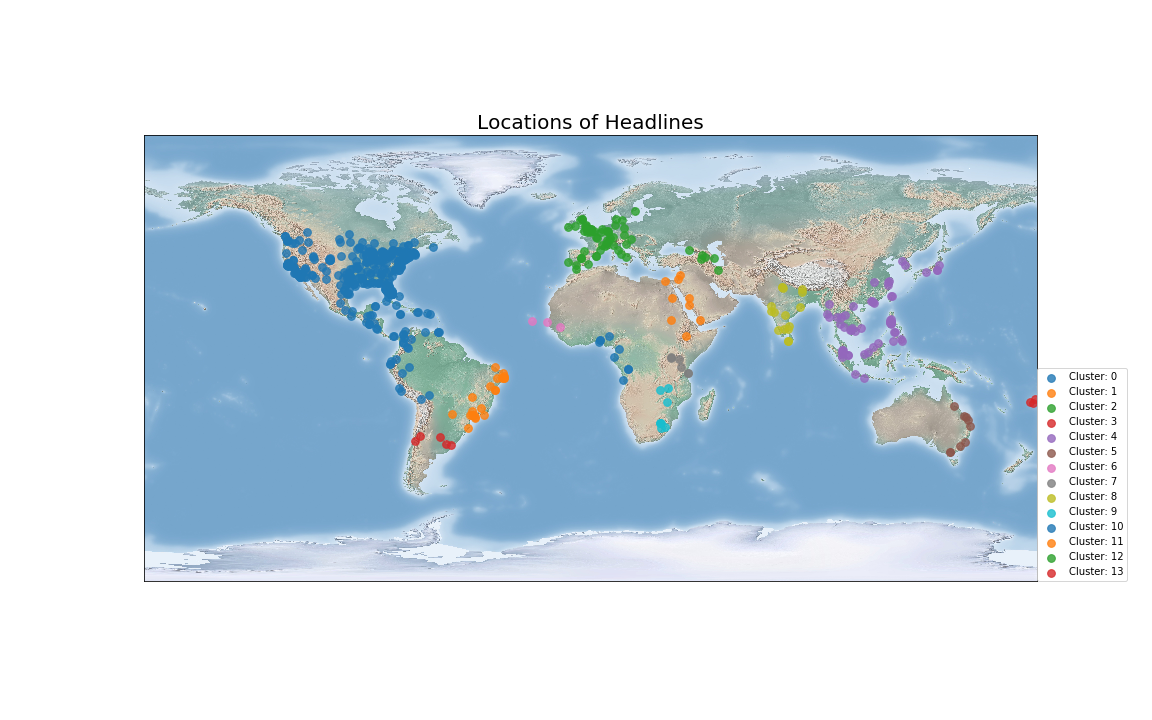

In [35]:
from IPython.display import Image

Image('../fentire_world_clustering.png')

In [36]:
data[['headline', 'city', 'latitude', 'longitude', 'countrycode', 'cluster']].to_csv('../data/clustered_data.csv')

From the cluster assignments and using the world map, we'll be able to identify outbreaks in the next section. However, this will require us to separate the data into a world and US set.

# Summary

In this notebook we:

* Applied the DBSCAN clustering method to the location data for cities mentioned in headlines
    - Started with the default parameters
* Altered the parameters of the DBSCAN algorithm to produce better clusters
    - Number of cities per cluster and distance between cities in a cluster were changed
* Visualized the clusters on a map to see if they are reasonable
* Evaluated different distance metrics for clustering
    - Used the Great Circle and Manhattan distance measures
* Tried another clustering method, KMeans on the headlines
    - KMeans limitations led us to choose DBSCAN
* Produced a final clustering and world image of the clusters

The end deliverable is a set of cluster labels assigned to headlines. We also have an image of the world with the clusters visualized. There are 14 reasonable clusters worldwide and a number of unassigned headlines considered noise by the algorithm. The next steps are to cluster the data for the US and the world separately and figure out if something connects the headlines in the same clusters. We'll take these on in the next section.